# Experiments on Wasserstein GANs

**Note**: The code was based on the implementation provided
in the paper "Training GANs with Optimism" [[1]](https://arxiv.org/pdf/1711.00141.pdf)


References:

[[1]](https://arxiv.org/pdf/1711.00141.pdf): Training GANs with Optimism ([arxiv link](https://arxiv.org/pdf/1711.00141.pdf), Github repo: [link](https://github.com/vsyrgkanis/optimistic_GAN_training))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import json

In [ ]:
# Utility functions
def plot_weights(w_D, v_G, w_D_RR, v_G_RR):
    """
    Plots weights of generator and discriminator for with-replacement and without-replacement sampling
    """
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(np.shape(w_D)[0]), w_D, label=['dimension 1', 'dimension 2'])
    plt.legend(title = "Descriminator")
    plt.title("Uniform Sampling SEG")
    plt.subplot(1,2,2)
    plt.plot(np.arange(np.shape(v_G)[0]), v_G, label=['dimension 1', 'dimension 2'])
    plt.legend(title ="Generator")
    plt.title("Uniform Sampling SEG")
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(np.shape(w_D_RR)[0]), w_D_RR, label=['dimension 1', 'dimension 2'])
    plt.legend(title = "Descriminator")
    plt.title("Random Reshuffling SEG")
    plt.subplot(1,2,2)
    plt.plot(np.arange(np.shape(v_G_RR)[0]), v_G_RR, label=['dimension 1', 'dimension 2'])
    plt.legend(title ="Generator")
    plt.title("Random Reshuffling SEG")
    plt.show()

    print("Recovered mean from generator: {}"
          .format(np.mean(v_G, axis=0)))
    print("Last mean from generator: {}".format(v_G[-1]))

def plot_error(relative_error, relative_error_RR, labels, x_label="Iterations (x$10^4$)", y_label="", title=''):
    """
    Plots the relative error of the with-replacement and without-replacement sampling experiment
    """
    plt.plot(np.arange(len(relative_error)), relative_error, label = labels[0], marker="o", markersize=10)
    plt.plot(np.arange(len(relative_error_RR)), relative_error_RR, label = labels[1], marker="p", markersize=10)
    plt.yscale('log')
    plt.grid(True)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.xlabel(x_label, fontsize=18)
    plt.title(title, fontsize=24)
    plt.legend(fontsize="18")
    plt.show()

In [ ]:
# Training functions
def stochastic_extragradient(v, T, eta_extrapol, eta_update, minibatch, rr=False, so=False, ig=False, n_trials=5, decreasing_step=False):

    # initialize variables
    dim = np.shape(v)[0]
    N = 100
    num_epochs = T // N
    w = 1.4*np.ones((T+1, dim))
    theta = 1.7*np.ones((T+1, dim))
    theta0 = theta[0,:]
    z0 = np.concatenate(([1.4, 1.4],[1.7, 1.7]))
    sol = np.transpose([0,0,3,4])
    relative_error = [0 for i in range(T)]
    xs = np.random.multivariate_normal(mean=v,
                                       cov = (1/10)*np.eye(dim),
                                       size=(N, 1))
    zs = np.random.multivariate_normal(mean=np.zeros(dim),
                                       cov = (1/10)*np.eye(dim),
                                       size=(N, 1))
    bxs = np.mean(xs, axis=1)
    bzs = np.mean(zs, axis=1)

    if ig:
      perm = range(N)

    # training
    for trial in range(n_trials):
      if so or rr:
         perm = np.random.permutation(range(N))
      index = 0
      for t in range(1,T+1):
          if(rr):
            if(t % N == 0 and t != 0):
              perm = np.random.permutation(range(N))
              index = 0
          if rr or so or ig:
              sample = perm[index % N]
              index += 1
          else:
            sample = np.random.randint(N)
          bxs_cur = bxs[sample]
          bzs_cur = bzs[sample]
          if(decreasing_step):
            eta_extrapol = 1.0/(t)
            eta_update = 1.0/(100*t)
          w_extrapolation = w[t-1] + eta_extrapol * (bxs_cur - bzs_cur - theta[t-1])
          theta_extrapolation = theta[t-1] + eta_extrapol * (w[t-1])
          w[t] = w[t-1] + eta_update * (bxs_cur - bzs_cur - theta_extrapolation)
          theta[t] = theta[t-1] + eta_update * (w_extrapolation)
          z = np.concatenate((w[t],theta[t]))
          relative_error[t-1] += (1/n_trials) *(np.linalg.norm(z - sol) / np.linalg.norm(z0 - sol))**2
    return w, theta, relative_error

def mean_learning_stochastic_omd(v, T, eta_D, eta_G, minibatch, rr=False, so=False, ig=False, n_trials=5):
    # initialize variables
    dim = np.shape(v)[0]
    N = 100
    num_epochs = T // N
    w = 1.4*np.ones((T+2, dim))
    theta = 1.7*np.ones((T+2, dim))
    theta0 = theta[0,:]
    z0 = np.concatenate(([1.4, 1.4],[1.7, 1.7]))
    sol = np.transpose([0,0,3,4])
    relative_error = [1]
    xs = np.random.multivariate_normal(mean=v,
                                       cov = np.eye(dim),
                                       size=(N, 1))
    zs = np.random.multivariate_normal(mean=np.zeros(dim),
                                       cov = np.eye(dim),
                                       size=(N, 1))
    bxs = np.mean(xs, axis=1)
    bzs = np.mean(zs, axis=1)
    initial_minibatch = np.random.randint(N, size=minibatch)
    bxs_prev, bzs_prev = np.zeros(dim), np.zeros(dim)
    for data in initial_minibatch:
      bxs_prev += bxs[data]
      bzs_prev += bzs[data]

    # training
    if ig:
      perm = range(N)

    for trial in range(n_trials):
      if so or rr:
         perm = np.random.permutation(range(N))
      index = 0
      for t in range(2,T+2):
        if(rr or so or ig):
          if( rr and index % N == 0 and t != 0):
            perm = np.random.permutation(range(N))
            index = 0
          # choose sample from permutation
          sample = perm[index % N: index % N + minibatch]
          index += minibatch
        else:
          sample = np.random.randint(N, size=minibatch)
        bxs_cur = np.zeros(2)
        bzs_cur = np.zeros(2)
        for data in sample:
          bxs_cur += bxs[data]
          bzs_cur += bzs[data]
        w[t] = w[t-1] + 2 * eta_D * (bxs_cur - bzs_cur - theta[t-1])  - eta_D * (bxs_prev - bzs_prev - theta[t-2])
        theta[t] = theta[t-1] + 2 * eta_G * (w[t-1]) - eta_G * (w[t-2])

        # update bxs, bzs
        bxs_prev = bxs_cur
        bzs_prev = bzs_cur

        # compute error
        z = np.concatenate((w[t],theta[t]))
        relative_error.append((1/n_trials) *(np.linalg.norm(z - sol) / np.linalg.norm(z0 - sol))**2)
    return w, theta, relative_error

In [1]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Learning the Mean of Multi-Variate Gaussians

We consider a setup where the data $x$ are generated from a multivariate normal
distribution with mean $v\in \mathbb{R}^d$.

In order to learn the mean of the multivariate Gaussian, we consider a Wasserstein GAN

with the following optimization objective:
\begin{equation}
\inf_{\theta} \sup_{w} \mathbb{E}_{x\sim N(v, I)}\left[ \langle w, x \rangle \right] - \mathbb{E}_{z\sim N(0,I)}\left[\langle w, z + \theta \rangle\right]
\end{equation}

The generator, in this case, is a linear function $G(z; \theta) = z + \theta$ of the parameter $\theta\in \mathbb{R}^d$

and aims to find the mean of the true distribution, which is the case when $\theta$ converges to $\theta = v$.

The discriminator is a linear function of the parameter $w \in \mathbb{R}^d$, i.e.: $
D(x; w) = \langle w, x \rangle$

and tries to distringuish the sample from the true distribution from those produced by the generator.



In [ ]:
# Parameters of distribution
dim = 2
v = [3, 4]

## Stochastic Algorithms

In the presence of sampling noise, we assume that we have $N$ samples $\{x_i\}_{i=1}^N$ and $N$ noise samples $\{z_i\}_{i=1}^N$ and we are trying to minimize the empirical loss:
\begin{equation}
\inf_{\theta} \sup_{w} \frac{1}{N} \sum_{i=1}^N \langle w, x_i \rangle - \frac{1}{n} \sum_{i=1}^N  \langle w, z_i + \theta \rangle
\end{equation}
We will use two stochastic algorithms for training the WGAN, namely:
- Stochastic Extragradient (SEG)
- Stochastic Optimistic Mirror Descent (SOMD) (similarly to [[1]]())


### Training with Stochastic Extragradient

In [ ]:
# define problem params
n = 100
D = 29*(n**2) -28*n +1
L_max_bil, L_bil = 1, 1
mu, mu_bil = 1, 1
A_const_bil = 4

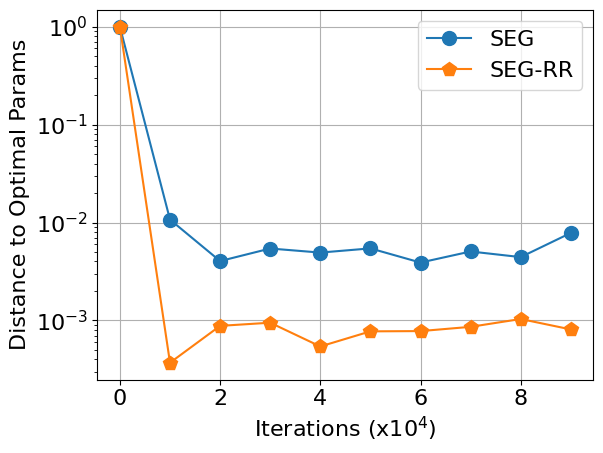

In [ ]:
gamma_1_max = 1/(100*L_max_bil)

# # Uncomment to run experiment
# w, theta, error = stochastic_extragradient(v, 100000, eta_extrapol=4*gamma_1_max, eta_update=gamma_1_max, minibatch=1) #eta_extrapol=0.15, eta_update=0.005
# w_RR, theta_RR, error_RR = stochastic_extragradient(v, 100000, eta_extrapol=4*gamma_1_max, eta_update=gamma_1_max, minibatch=1, rr=True)
# # save results
# data = {"SEG_RR_error": error_RR,
#            "SEG_error": error}
# with open('./drive/My Drive/results/wgan_steps_100L.json', 'w') as json_file:
#     json.dump(data, json_file)

# # load results
with open('./drive/My Drive/results/wgan_steps_100L.json', 'rb') as json_file:
    data = json.load(json_file)
error = data["SEG_error"]
error_RR = data["SEG_RR_error"]
# sparsify vectors
sparsified_error = [error[i] for i in range(len(error)) if i % 10**4 == 0]
sparsified_error_RR = [error_RR[i] for i in range(len(error)) if i % 10**4 == 0]

plt.plot(np.arange(len(sparsified_error)), sparsified_error, label = 'SEG', marker="o", markersize=10)
plt.plot(np.arange(len(sparsified_error_RR)), sparsified_error_RR, label = 'SEG-RR', marker="p", markersize=10)

plt.yscale('log')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Distance to Optimal Params", fontsize=16)
plt.xlabel("Iterations (x$10^4$)", fontsize=16)
plt.title('', fontsize=24)
plt.legend(fontsize="16")
plt.show()

plt.savefig("/content/SEG-RR_vs_SEG"+".pdf", format="pdf", bbox_inches="tight")

### Training with Optimistic MD

The experimental setup is the same as in [[1]](https://arxiv.org/pdf/1711.00141.pdf).

3000001


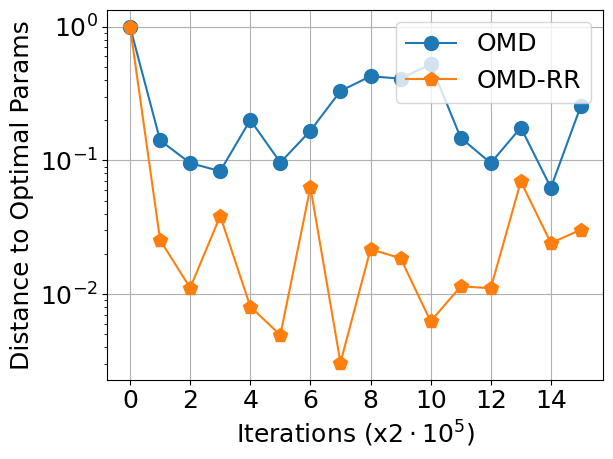

In [ ]:
## Stochastic Optimistic GD Training on Sampled Loss

# # uncomment to run experiment
# w, theta, error = mean_learning_stochastic_omd(v, 1000000, 2e-2, 1e-2, minibatch=1, rr= False, n_trials=5)
# print("second --------")
# w, theta, error_RR = mean_learning_stochastic_omd(v, 1000000, 2e-2, 1e-2, minibatch=1, rr=True, n_trials=5)
# # save results
# data = {"error_SEG_RR": error_RR, "error_SEG": error}
# with open('./drive/My Drive/results/wgan_omd_minibatch_1.json', 'w') as json_file:
#     json.dump(data, json_file)

# # load results
with open('./drive/My Drive/results/wgan_omd_minibatch_1.json', 'rb') as json_file:
    data = json.load(json_file)
error_RR = data["error_SEG_RR"]
error = data["error_SEG"]

print(len(error))
sparsified_error = [error[i] for i in range(len(error)) if i % (2 *10**5) == 0]
sparsified_error_RR = [error_RR[i] for i in range(len(error)) if i %(2* 10**5) == 0]

plot_error(sparsified_error, sparsified_error_RR, ["OMD", "OMD-RR"], title="", y_label="Distance to Optimal Params", x_label="Iterations (x$2\cdot 10^5$)")
plt.savefig("/content/OMD-RR_vs_OMD"+".pdf", format="pdf", bbox_inches="tight")